# Predict cell count based on morphology

Author: Jess Ewald

I suspect that cell count is a learnable label simply due to its relationship with cell density and therefore area, which impacts many morphological features in a non-linear way. Here, I take batch 7 cells, compute the cell count for each well, filter to remove any well with less than 10 cells, choose 20% alleles randomly and put into a test dataset. With the remaining cells, I will train a model to predict the cell count label for the well that each cell comes from. I will evaluate the model on the held out cells. This should tell me how much of the signal can be directly attributed to smushing cells together. If the signal is very strong/predictable, then this could explain detected differences between WT-VAR pairs if there is a very big difference in cell count. 

In [66]:
# imports
import polars as pl
import numpy as np
import os
import random
import cupy as cp
import xgboost as xgb
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns

import black
import jupyter_black

jupyter_black.load(
    lab=False,
    line_length=79,
    verbosity="DEBUG",
    target_version=black.TargetVersion.PY310,
)

import warnings
warnings.filterwarnings("ignore")

In [2]:
# paths
dat_dir = "/dgx1nas1/storage/data/jess/repos/2021_09_01_VarChAMP/6.downstream_analysis_snakemake/outputs/batch_profiles/2024_01_23_Batch_7"

In [3]:
# Get cell count per well
cc = pl.scan_parquet(f"{dat_dir}/profiles_tcdropped_filtered_var_mad_outlier_featselect.parquet")
cc = cc.select(['Metadata_well_position', 'Metadata_Plate', 'Metadata_gene_allele']).collect()
cc = cc.group_by(['Metadata_well_position', 'Metadata_Plate', 'Metadata_gene_allele']).agg(pl.count().alias("Cell_count"))
cc = cc.filter(pl.col("Cell_count") >= 10)
cc = cc.with_columns(
    pl.concat_str([pl.col("Metadata_Plate"),
                    pl.col("Metadata_well_position"),
                    pl.col("Metadata_gene_allele")],
                    separator="_").alias("Metadata_WellID")
)

In [4]:
# Split variants into train and test set
variants = cc.select("Metadata_gene_allele").to_series().unique().sample(fraction=1, shuffle=True).to_list()
split_index = int(0.8 * len(variants))
variants_train = variants[:split_index]
variants_test = variants[split_index:]


In [5]:
# Get training df
df_train = pl.scan_parquet(f"{dat_dir}/profiles_tcdropped_filtered_var_mad_outlier_featselect.parquet")
df_train = df_train.filter(pl.col("Metadata_gene_allele").is_in(variants_train)).with_columns(
    pl.concat_str([pl.col("Metadata_Plate"),
                    pl.col("Metadata_well_position"),
                    pl.col("Metadata_gene_allele")],
                    separator="_").alias("Metadata_WellID")
).collect()

df_train = df_train.join(cc.select(["Metadata_WellID", "Cell_count"]), on="Metadata_WellID")

In [35]:
# Sample 10 cells per well for training
df_train_sampled = df_train.groupby('Metadata_WellID').apply(
    lambda group: group.sample(n=min(len(group), 10), with_replacement=False)
)

In [36]:
target = "Cell_count"
feat_cols = [i for i in df_train_sampled.columns if "Metadata_" not in i]
feat_cols = [i for i in feat_cols if "Cell_count" not in i]
meta_cols = [i for i in df_train_sampled.columns if "Metadata_" in i]

In [37]:
# Train model
x_train = df_train_sampled.select(feat_cols).to_numpy()
y_train = df_train_sampled.select(target).to_numpy()

model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=150,
    tree_method="hist",
    learning_rate=0.05,
    device="cuda"
).fit(x_train, y_train, verbose=False)


In [38]:
# Get test data
df_test = pl.scan_parquet(f"{dat_dir}/profiles_tcdropped_filtered_var_mad_outlier_featselect.parquet")
df_test = df_test.filter(pl.col("Metadata_gene_allele").is_in(variants_test)).with_columns(
    pl.concat_str([pl.col("Metadata_Plate"),
                    pl.col("Metadata_well_position"),
                    pl.col("Metadata_gene_allele")],
                    separator="_").alias("Metadata_WellID")
).collect()

df_test = df_test.join(cc.select(["Metadata_WellID", "Cell_count"]), on="Metadata_WellID")

x_test = df_test.select(feat_cols).to_numpy()
y_test = df_test.select(target).to_numpy()


In [40]:
# Predict cell count
predictions = model.predict(x_test)


In [50]:

res = pl.DataFrame({
    "Metadata_Well_ID": df_test.select("Metadata_WellID").to_series().to_list(),
    "Cell_count": y_test.flatten().tolist(),
    "Predicted_cell_count": predictions
})

In [51]:
res

Metadata_Well_ID,Cell_count,Predicted_cell_count
str,i64,f32
"""2024_01_17_B7A…",50,135.526505
"""2024_01_17_B7A…",50,272.571808
"""2024_01_17_B7A…",50,84.78508
"""2024_01_17_B7A…",50,36.176178
"""2024_01_17_B7A…",50,93.284821
"""2024_01_17_B7A…",50,107.9953
"""2024_01_17_B7A…",50,109.640579
"""2024_01_17_B7A…",50,71.121902
"""2024_01_17_B7A…",50,199.690674


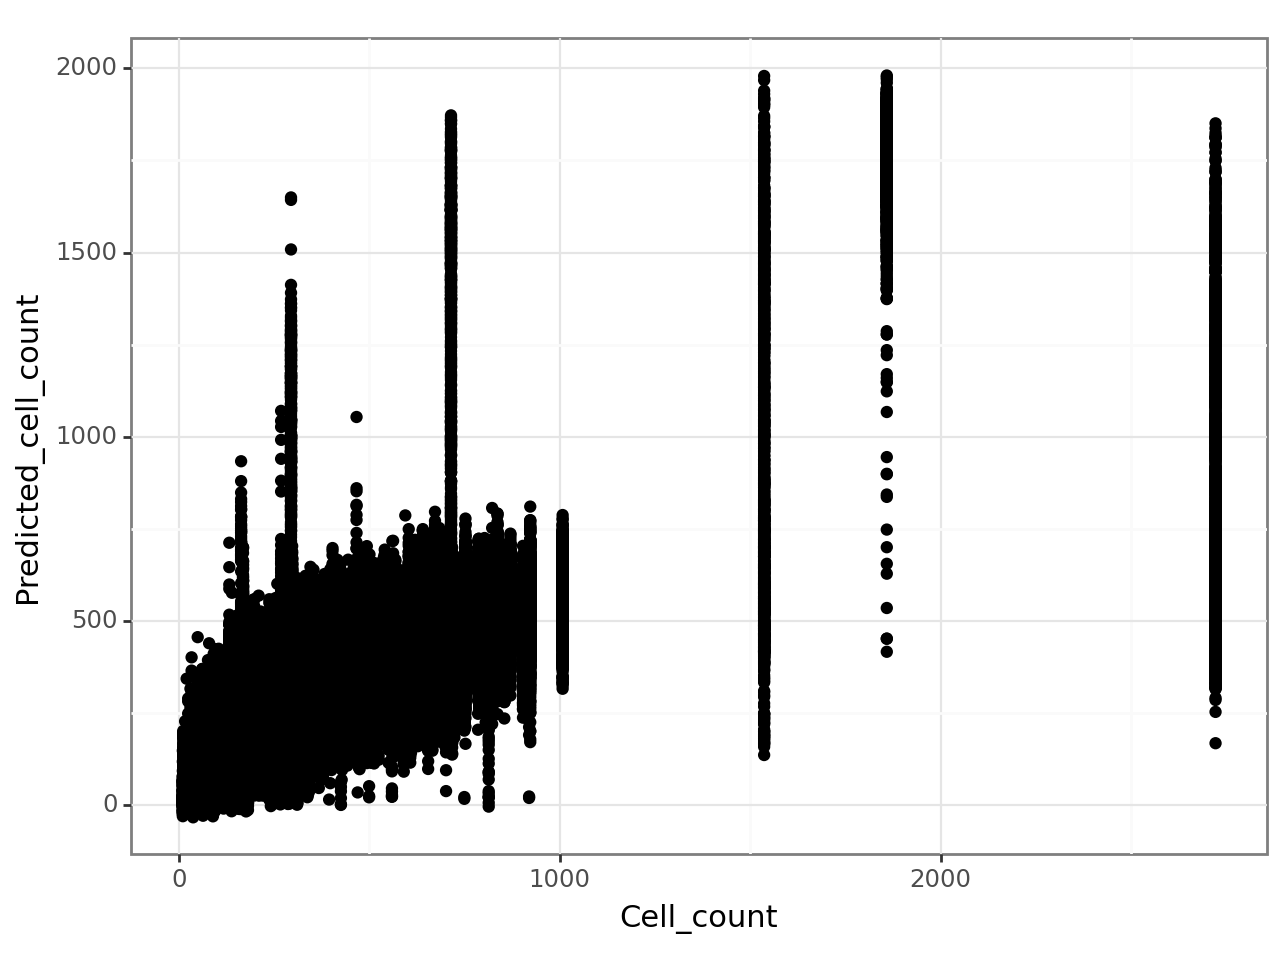

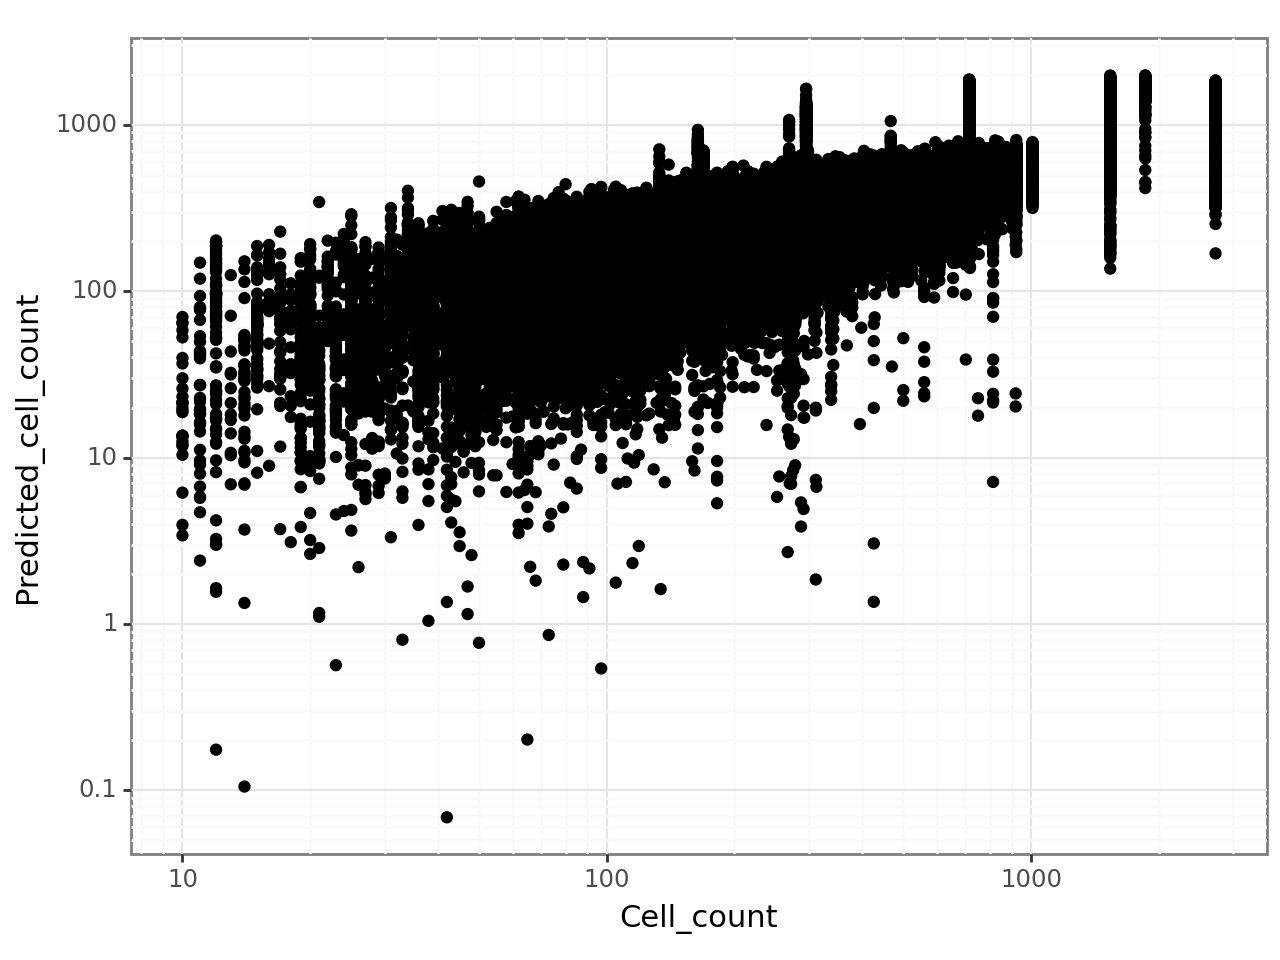

In [53]:
from plotnine import *

plot1 = (ggplot(res)
         + aes(x="Cell_count", y="Predicted_cell_count")
         + geom_point()
         + theme_bw())
print((plot1))

plot2 = (ggplot(res)
         + aes(x="Cell_count", y="Predicted_cell_count")
         + geom_point()
         + scale_y_log10()
         + scale_x_log10()
         + theme_bw())
print((plot2))

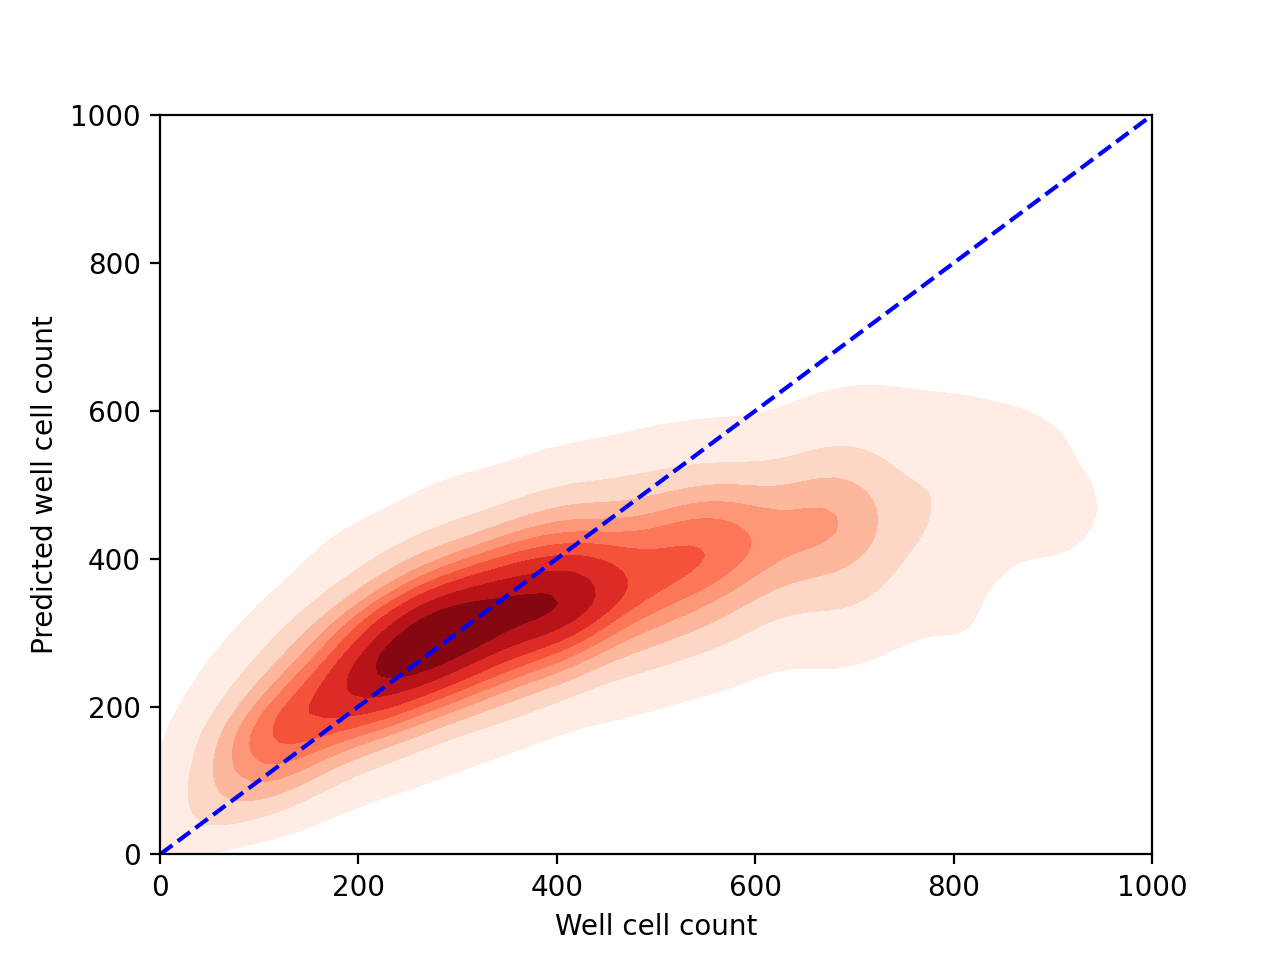

In [68]:
sns.kdeplot(data = res.to_pandas(), x="Cell_count", y="Predicted_cell_count", cmap="Reds", fill=True)
plt.xlabel('Well cell count')
plt.ylabel('Predicted well cell count')
plt.xlim(0, 1000)
plt.ylim(0, 1000)
plt.plot([0, 1000], [0, 1000], ls="--", c="blue")
plt.show()

In [65]:
res = res.filter((pl.col("Cell_count") > 0) & (pl.col("Predicted_cell_count") > 0)).with_columns(
    (pl.col("Cell_count").log10().alias("Log_CC")),
    (pl.col("Predicted_cell_count").log10().alias("Log_PCC"))
)

# Calculate R-squared
print(stats.pearsonr(
    res.select("Cell_count").to_series(),
    res.select("Predicted_cell_count").to_series()
))

print(stats.pearsonr(
    res.select(pl.col("Log_CC")).to_series(),
    res.select(pl.col("Log_PCC")).to_series()
))

PearsonRResult(statistic=0.6896960542515139, pvalue=0.0)
PearsonRResult(statistic=0.7640009864161076, pvalue=0.0)
